In [207]:
import torch, pickle, sys
sys.path.append('/home/dgotzens/scripts')
import pdfdefaults as pdf
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
from math import sin,cos,sqrt,log10
pi = 3.141592653589 
maxdist = 50
c0 = 299_792_458 
f0, f1 = 76_009_996_288.0, 80_289_505_280.0
omega0, omega1 = 2*pi*f0, 2*pi*f1

t_chirp = 0.000_064_890_002_249_740_060
fs = 22e6
Ts=1/fs
M,K = 1022,192

omegadot = (omega1-omega0)/t_chirp

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
params = pickle.load(open(folder+'feparams.pkl', 'rb'))

tx,ty,rx,ry,vx,vy = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY'], params['vxPosX'], params['vxPosY']


settings = {'channel gain':     torch.ones(K),
# settings = {'channel gain':     ch_window/ch_window.sum(),
            'chirp slope':      (f1-f0)/t_chirp,
            'start frequency':  f0,
            'sample period':    Ts,
            'lightspeed':       c0,
            'y_tx' :            params['txPosY'],
            'x_tx' :            params['txPosX'],
            'y_rx' :            params['rxPosY'],
            'x_rx' :            params['rxPosX']}
  
def calc_image_bp(data, settings, pos):
    M,K,L = data.shape
    PP = pos.shape

    gain = settings['channel gain']                     # PP x K
    slope = settings['chirp slope']
    f0 = settings['start frequency']
    Ts = settings['sample period']


    #omegadot * tau * torch.arange(0,M)[:,None,None]*Ts + 1j*omega0*tau
    # Compute weights
    tau = time_of_flight(settings, pos).unsqueeze(-2)   # PP x 1 x K
    t = Ts*torch.arange(M)[:,None]                      # M x 1
    frequency = 2*pi*slope*tau
    phase = 2*pi*f0*tau                 # PP x M x K
    weights = gain.unsqueeze(-2) * torch.exp(1j*phase) * torch.exp(1j*frequency*t)  # PP x M x K
    # weights *= torch.hamming_window(M)[:,None]
    print(weights.shape)
    # Compute 3D Images
    imgs = torch.stack([(weights.conj() *  data[:,:,l]).sum((-2,-1)) for l in range(L)], -1)
    return imgs

def time_of_flight(settings, pos):
    x_tx, x_rx = settings['x_tx'], settings['x_rx']
    y_tx, y_rx = settings['y_tx'], settings['y_rx']
    K=len(x_tx)
    c0 = settings['lightspeed']

    txpos = torch.tensor([x_tx,y_tx,[0]*K]).transpose(0,1)
    rxpos = torch.tensor([x_rx,y_rx,[0]*K]).transpose(0,1)
    # K x 3                   
    pos = pos.unsqueeze(-2)
    # PP x 1 x 3   
    r_tx = (txpos-pos).square().sum(-1).sqrt()  
    r_rx = (rxpos-pos).square().sum(-1).sqrt()
    # sum(PPx1x3 - Kx3, -1) = PPxK
    return (r_tx+r_rx)/c0  


dBr = lambda x: 20*(x/x.abs().max()).log10()


In [208]:
# dists = torch.tensor([.3,.5,1,2,5,10,15,25,40])
dists = torch.tensor([.1,10,50])
D=len(dists)
target_pos = torch.stack([torch.zeros(D),torch.zeros(D), cos(30*pi/180)*dists], -1)
tau = time_of_flight(settings,target_pos).T # KxD

data = torch.exp(1j * omegadot * tau * torch.arange(0,M)[:,None,None]*Ts)
data *= torch.exp(1j*omega0 * tau)
print(data.shape)

N = 400
angle = torch.linspace(-60,60,N) * pi/180
pos = dists[:,None,None] * torch.stack([angle.sin(), torch.zeros(N), angle.cos()], -1)
# imgs = calc_image_bp(data,settings,pos)

torch.Size([1022, 192, 3])


In [209]:
pos = dists[:,None,None] * torch.stack([angle.sin(), torch.zeros(N), angle.cos()], -1)
tau = time_of_flight(settings, pos)
window = torch.empty_like(tau)
W = 2_000_000
w = torch.hann_window(W)
print(tau.shape)
for n in range(N):
    for d in range(D):
        tau_max = tau[d,n,:].max()
        tau_min = tau[d,n,:].min()
        idx = (W * (tau[d,n,:]-tau_min)/(tau_max-tau_min)).int()
        window[d,n,:] = w[idx-1]

torch.Size([3, 400, 192])


In [210]:
D=len(dists)
target_angle = -20
target_pos = dists[:,None]*torch.tensor([sin(target_angle/180*pi), 0,cos(target_angle/180*pi)])
tau = time_of_flight(settings,target_pos).T ## KxD

data = torch.exp(1j * omegadot * tau * torch.arange(M)[:,None,None]*Ts)*torch.exp(1j*omega0*tau)
print(data.shape)

torch.Size([1022, 192, 3])


torch.Size([3, 400, 192])


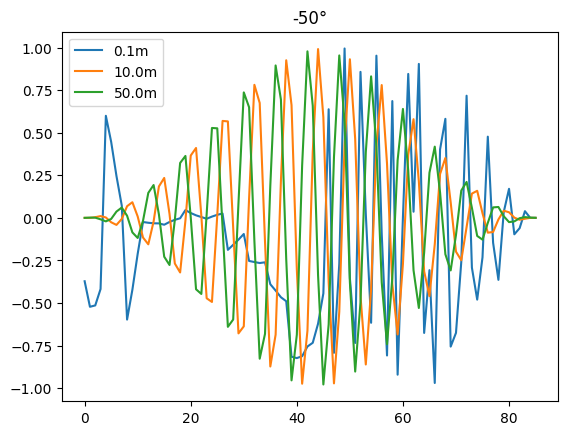

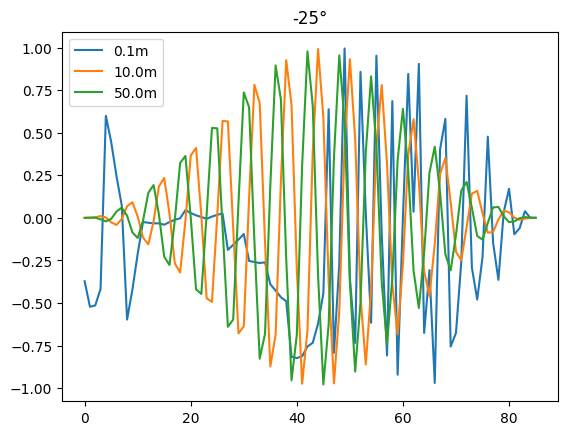

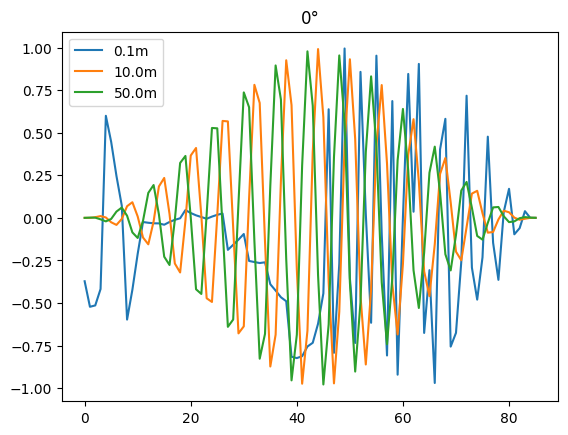

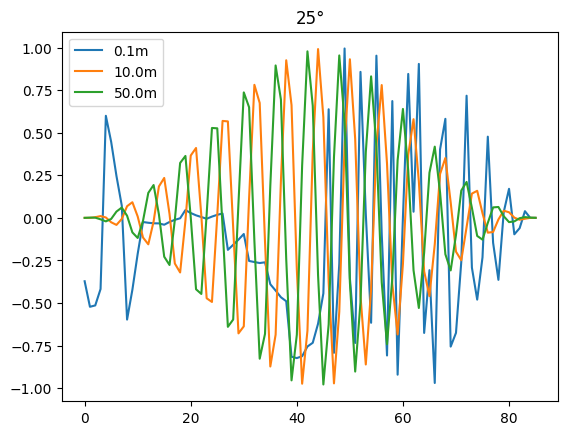

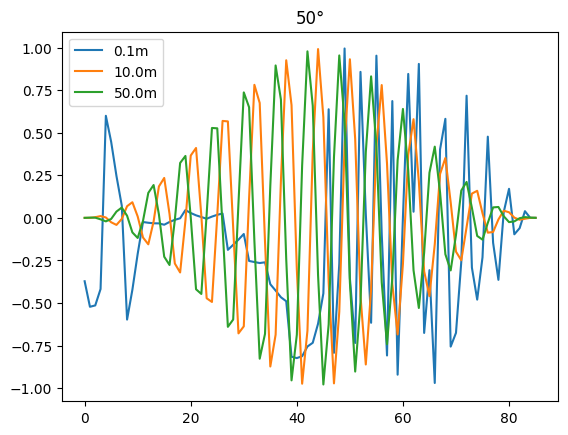

In [211]:
ula = torch.tensor([[x if y==0 else -100 for x,y in zip(vx,vy)].index(x) for x in range(max(vx)+1)])
settings['channel gain'] = window[:,:,ula]
settings['y_tx'] = [params['txPosY'][k] for k in ula]
settings['x_tx'] = [params['txPosX'][k] for k in ula]
settings['y_rx'] = [params['rxPosY'][k] for k in ula]
settings['x_rx'] = [params['rxPosX'][k] for k in ula]
# imgs = calc_image_bp(data[:,ula,:],settings,pos)
print(window.shape)

for angle in (-50,-25,0,25,50):
    plt.title(f'{angle}°')
    for d,dist in enumerate(dists[:4]):
        plt.plot(data.real[0,ula,d]*window[d,N//2 + target_angle,ula], label=f'{round(float(dist),1)}m')
    plt.legend()
    plt.show()

# for angle in (-50,-25,0,25,50):
#     plt.title(f'{angle}°')
#     for d,dist in enumerate(dists[:4]):
#         plt.plot(window[d,N//2 + angle,ula], label=f'{round(float(dist),1)}m')
#     plt.legend()
#     plt.show()


torch.Size([3, 400, 1022, 86])


ValueError: x and y must have same first dimension, but have shapes (1,) and torch.Size([400])

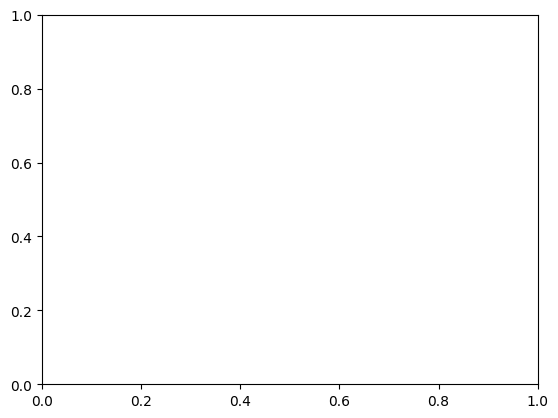

In [212]:
imgs = calc_image_bp(data[:,ula,:], settings, pos)
fig, ax = plt.subplots(1)
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for d,dist in enumerate(dists):
    ax.plot(angle*180/pi, dBr(imgs[d,:,d].abs()), label=f'{dist:.1f}m', linewidth=1)
    # ax.plot(angle*180/pi, dBr(imgs[d,:,d].abs()), label=f'{dist:.1f}m', linewidth=0.2+d*0.1)
fig.set_figwidth(0.7*pdf.a4_textwidth)
ax.xaxis.set_major_formatter(EngFormatter('°'))
ax.yaxis.set_major_formatter(EngFormatter('dBr'))
# ax.set_ylim(-60,3)
# ax.set_xlim(-60,60)
# ax.set_yticks(torch.linspace(-20,10/3,8), minor=True)
# ax.set_yticks(range(-20,1,10), minor=False)
# ax.set_xticks(torch.linspace(-90,90,19), minor=True)
# ax.set_xticks(torch.linspace(-90,90,7), minor=False)
ax.grid(which='major')
# ax.grid(linestyle=':', which='minor')
fig.legend(*ax.get_legend_handles_labels(), bbox_to_anchor=(0.5,0), loc='upper center', ncols=3)
fig.set_size_inches(10,7)
# fig.savefig('/home/dgotzens/thesis/figures/bp_elv_peak.pdf')
